# Atmospheric Rivers: Filtering by Criteria

This notebook will import functions from the `ar_detection.py` module to expose the processing flow and to show a few examples.
Production runs could also be orchestrated from this notebook to leverage the use of an interactive Dask client if/when needed. Before executing this notebook be sure you've set your `AR_DATA_DIR` environment variable, and have executed both the `download.py` and `compute_ivt.py` scripts.

In [1]:
import random

import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm

from config import ar_params, ard_fp, shp_fp

# functions to create the binary "blobs" of IVT exceedance
from ar_detection import compute_intensity_mask, label_contiguous_mask_regions
# functions to measure the requisite blob properties
from ar_detection import generate_region_properties, get_data_for_ar_criteria, get_azimuth_of_furthest_points, get_directional_coherence, get_length_width_ratio, get_major_axis_haversine_distance, get_poleward_strength
# functions test whether or not criteria are met
from ar_detection import apply_criteria, filter_ars
# functions to generate vectorized output
from ar_detection import create_geodataframe_with_all_ars, create_shapefile

In [2]:
# inspect criteria, note that `window` and `ivt_percentile` are used in the IVT computation, not in the AR filtering done here
ar_params

{'window': 75,
 'ivt_percentile': 85,
 'ivt_floor': 100,
 'direction_deviation_threshold': 45,
 'mean_meridional': 50,
 'orientation_deviation_threshold': 45,
 'min_axis_length': 2000}

In [3]:
ivt_ds = xr.open_dataset(ard_fp)
ivt_ds.rio.write_crs("epsg:4326", inplace=True)
ivt_ds

<xarray.Dataset>
Dimensions:       (time: 4384, latitude: 225, longitude: 237)
Coordinates:
  * time          (time) datetime64[ns] 2019-01-01 ... 2021-12-31T18:00:00
  * longitude     (longitude) float32 -179.0 -178.8 -178.5 ... -120.2 -120.0
  * latitude      (latitude) float32 66.0 65.75 65.5 65.25 ... 10.5 10.25 10.0
    spatial_ref   int64 0
Data variables:
    p72.162       (time, latitude, longitude) float32 ...
    ivt_mag       (time, latitude, longitude) float32 ...
    ivt_dir       (time, latitude, longitude) float32 ...
    ivt_quantile  (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-31 23:12:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [4]:
%%time
ivt_ds["thresholded"] = compute_intensity_mask(ivt_ds["ivt_mag"], ivt_ds["ivt_quantile"], ar_params["ivt_floor"])

CPU times: user 1.78 s, sys: 1.44 s, total: 3.22 s
Wall time: 3.22 s


In [5]:
%%time
labeled_regions = label_contiguous_mask_regions(ivt_ds["thresholded"])

CPU times: user 6.81 s, sys: 253 ms, total: 7.07 s
Wall time: 7.06 s


In [6]:
%%time
ar_di = generate_region_properties(labeled_regions, ivt_ds)

CPU times: user 36 s, sys: 3.86 s, total: 39.9 s
Wall time: 39.9 s


In [7]:
%%time
ar_di = get_data_for_ar_criteria(ar_di, ivt_ds)

Getting axis length (km) for each AR target:: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:59<00:00, 73.44it/s]
Getting overall orientation (azimuth) for each AR target:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:47<00:00, 91.80it/s]
Getting mean poleward strength for each AR target:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:05<00:00, 867.69it/s]
Getting directional coherence for each AR target:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:16<00:00, 266.76it/s]

CPU times: user 2min 32s, sys: 3.11 s, total: 2min 35s
Wall time: 2min 34s


In [8]:
%%time
ar_di = apply_criteria(ar_di)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:00<00:00, 19713.82it/s]

CPU times: user 218 ms, sys: 12.1 ms, total: 230 ms
Wall time: 226 ms


In [9]:
%%time
# how many criteria must be satisfied to be considered an AR?
# default is the maximum (5), but this may need to be tweaked
# some criteria (overall orientation consistency) may oscillate between pass and fail depending on size of spatial domain
output_ars = filter_ars(ar_di, n_criteria_required=5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:00<00:00, 157307.48it/s]

CPU times: user 34.4 ms, sys: 1.14 ms, total: 35.6 ms
Wall time: 32.1 ms


Text(0.5, 1.0, 'AR candidate blobs')

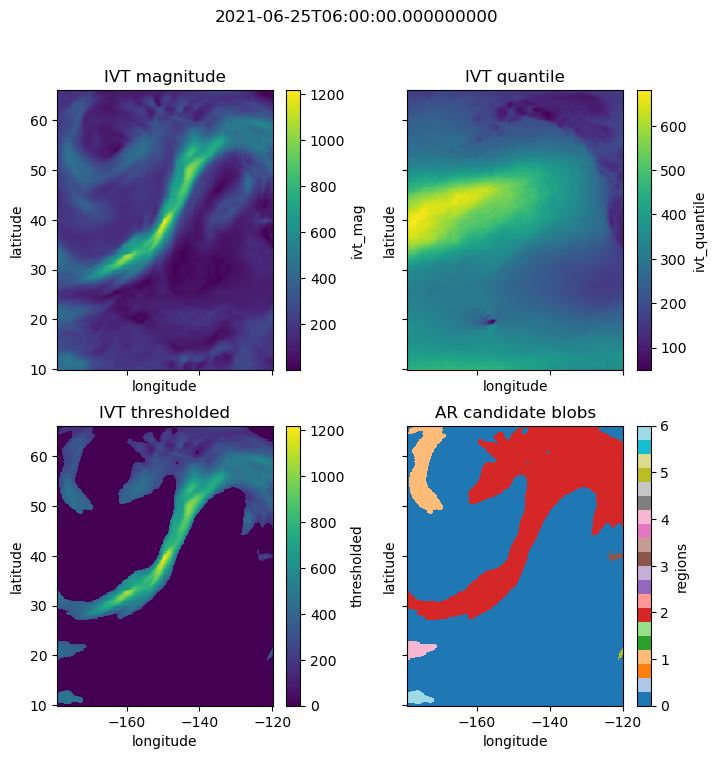

In [16]:
random_date = random.choice(list(output_ars.keys()))
fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(8,8))
plt.subplots_adjust(wspace=0.3)
plt.suptitle(random_date)

ivt_ds["ivt_mag"].sel(time=random_date).plot(ax=axes[0,0])
ivt_ds["ivt_quantile"].sel(time=random_date).plot(ax=axes[0,1])
ivt_ds["thresholded"].sel(time=random_date).plot(ax=axes[1,0])
labeled_regions.sel(time=random_date).plot(ax=axes[1,1], cmap="tab20")

axes[0,0].set_title("IVT magnitude")
axes[0,1].set_title("IVT quantile")

axes[1,0].set_title("IVT thresholded")
axes[1,1].set_title("AR candidate blobs")

In [11]:
output_ars["2019-01-23T18:00:00.000000000"]

3

In [12]:
single_ar_for_testing_shp_output = {"2019-01-23T18:00:00.000000000": 3}

In [13]:
%%time
# this may be a good target for dask, because it is slow
# also, this is a hacky implementation of xarray slice to shapefile so maybe just replace this function!
# all ARs
# create_geodataframe_with_all_ars(output_ars, ar_di, labeled_regions)
output_ar_gdf = create_geodataframe_with_all_ars(single_ar_for_testing_shp_output, ar_di, labeled_regions)
output_ar_gdf

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.76s/it]

CPU times: user 17.8 s, sys: 17.3 ms, total: 17.8 s
Wall time: 17.8 s


,geometry,mean IVT,max IVT,min IVT,time
_column,,,,,
0,"POLYGON ((-179.00000 25.75000, -179.00000 26.0...",636,1126,296,2019-01-23T18:00:00.000000000


In [14]:
create_shapefile(output_ar_gdf, shp_fp)

In [15]:
ivt_ds.close()